In [1]:
import numpy as np
import pandas as pd 
import string
import spacy
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
K = keras.backend
from sklearn.model_selection import train_test_split
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.base import TransformerMixin, BaseEstimator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glovedata/glove.6B.200d.txt
/kaggle/input/glovedata/glove.6B.50d.txt
/kaggle/input/glovedata/glove.6B.100d.txt


# Load and review data

In [2]:
# loading train and test set from kaggle public datasets
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

train.sample(10)

,id,keyword,location,text,target
2416,3475,derailed,"Enterprise, Alabama",Has #IdentityTheft Derailed Your #TaxReturn? \...,0
5717,8159,rescuers,NaN,WomanÛªs GPS app guides rescuers to injured b...,1
7325,10485,wildfire,"Tucson, AZ",Does the #FingerRockFire make you wonder 'am I...,1
7028,10073,typhoon,NaN,Obama Declares Disaster for Typhoon-Devastated...,1
5067,7224,natural%20disaster,NaN,Suncorp net profit rises to $1.13 billion in w...,1
5832,8332,rubble,California,China's Stock Market Crash: Are There Gems In ...,0
2438,3501,derailed,Headed To The Top,@OhYayyyYay the train derailed this morning,1
971,1406,body%20bag,"California, USA",?Ìü New Ladies Shoulder Tote #Handbag Faux Lea...,0
6718,9620,thunderstorm,"El Dorado, Arkansas",NWS has Continued a Severe Thunderstorm Warnin...,1
1809,2599,crash,NaN,Crash helmet silvery floors karnal fat shoot s...,0


In [3]:
# common abbreviations and contractions
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bro" : "brother",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "tv": "television",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired",
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "couldnt" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "doesnt" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "havent" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "im": 'I am',
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "shouldnt" : "should not",
    "that's" : "that is",
    "thats" : "that is",
    "there's" : "there is",
    "theres" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "theyre":  "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not"
}

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# drop duplicates
train.drop_duplicates(subset=['text'], inplace=True)

# get the features we want to analyze
X_train = train['text'] 
# the labels
y_train = train['target'] 

X_test = test['text'] 

# Data Preprocessing

In [6]:
# Create our list of punctuation marks
punctuations = string.punctuation
punctuations += '...'
punctuations += '....'

# Create list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Preliminary text cleaning
class Cleaner(TransformerMixin):
    
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

def clean_text(text):
    # split data entry
    text = text.split()
    # omit hashtags
    text = [word for word in text if not word.startswith('#')]
    # join data entry back for tokenization and lemmatization
    text = ' '.join(text)
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(text)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    # remove non-ascii
    mytokens_enc = [word.encode("ascii", "ignore") for word in mytokens]
    mytokens = [word.decode() for word in mytokens_enc]
    # Remove stop words
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    # replace numbers with 'number' token
    mytokens = [word if not word.isnumeric() else 'number' for word in mytokens]
    # replace abbreviations
    mytokens = [abbreviations[word] if word in abbreviations.keys() else word for word in mytokens]
    # remove mentions
    mytokens = [word if not word.startswith('@') else 'user' for word in mytokens]
    # removing URLs
    mytokens = [word if not word.startswith('http') else 'url' for word in mytokens]
    # remove other encodings
    mytokens = [word for word in mytokens if not word.__contains__('\x89')]
    # remove out-of-vocabulary symbols
    mytokens = [word for word in mytokens if not word.__contains__('amp')]
    # strip any '/' character 
    mytokens = [word.replace('/', '') for word in mytokens]
    # remove 2-letter words
    mytokens = [word for word in mytokens if len(word) > 2]
    # remove non-alphabetic words
    mytokens = [word for word in mytokens if word.isalpha()]
    return mytokens

# Vocabulary reduction

In [7]:
# get train data vocabulary
def get_vocab(data):
    # instantiate Counter()
    vocab = Counter()
    # preprocess data
    cleaned = Cleaner().fit_transform(data)
    # count number of each word occurrences in data 
    for line in cleaned:
        vocab.update(line)
    return vocab

# keep tokens with a min occurrence
def reduce_vocab(min_occurane):
    tokens = [k for k, c in vocab.items() if c >= min_occurane]
    return tokens

In [8]:
# final cleaning of data: omit words that are not present in reduced vocabulary
def reduced_vocab_data(data, vocab):
    reduced_data = []
    # walk through preprocessed data
    for line in data:
        # get only those words that are in reduced vocabulary
        tokens = [word for word in line if word in vocab]
        # update list with cleaned line of data
        reduced_data.append(' '.join(tokens))
    return reduced_data

# Linear Classifiers

In [9]:
# split the dataset into training and validation sets
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [10]:
# get a list of classifiers along with their names for evaluation on the dataset
classifiers = [('lr', LogisticRegression()),
              ('svc', SVC()),
              ('gbc', GradientBoostingClassifier(n_estimators=200))]

# transform text into normalized bag-of-words
tfidf_vector = TfidfVectorizer(tokenizer=clean_text)

# Create a pipeline for each individual classifier by putting the text vectorizer in front of it
def get_pipe(classifiers):
    pipes = []
    for classifier in classifiers:
        pipes.append((classifier[0], Pipeline([('vectorizer', tfidf_vector), classifier])))
    return pipes

pipes = get_pipe(classifiers)

# evaluate created pipelines
for pipe in pipes:
    # model generation
    pipe[1].fit(X_t, y_t)

    # Predicting with a test dataset
    predicted = pipe[1].predict(X_v)

    # Model Accuracy
    print(pipe[0] + ':', metrics.accuracy_score(y_v, predicted))

lr: 0.7877442273534636
svc: 0.7921847246891652
gbc: 0.7557726465364121


In [11]:
# get a stacking ensemble of models
def get_stacking(pipes):
    # define the base models
    level0 = list()
    for pipe in pipes:
        level0.append((str(pipe[0]), pipe[1]))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)
    return model

# Get a stacking ensemble, fit it to the data, and evaluate
stacking = get_stacking(pipes)
stacking.fit(X_t, y_t)
predicted = stacking.predict(X_v)
# Model Accuracy
print('stacking:', metrics.accuracy_score(y_v, predicted))

stacking: 0.7948490230905861


In [12]:
# a submission file
test["target"] = stacking.predict(X_test)
submission = test[["id", "target"]]
submission.to_csv("sub_st.csv",index=False)

# Multichannel Convolutional Neural Network

## Tokenization & Encoding

In [13]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the maximum document length
def max_length(lines):
    return int(np.mean([len(line) for line in lines]))

In [14]:
# encode data
def encode_data(tokenizer, lines, size):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=size, padding='post')
    return padded

## Define model

In [15]:
# define model
def define_model(length, vocab_size):
    # channel 1
    input1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 25)(input1)
    conv1 = Conv1D(filters=8, kernel_size=2, activation='elu')(embedding1)
    drop1 = Dropout(0.4)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    input2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 25)(input2)
    conv2 = Conv1D(filters=8, kernel_size=3, activation='elu')(embedding2)
    drop2 = Dropout(0.4)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    input3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 25)(input3)
    conv3 = Conv1D(filters=8, kernel_size=4, activation='elu')(embedding3)
    drop3 = Dropout(0.4)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    drop4 = Dropout(0.1)(merged)
    dense2 = Dense(10, activation='elu')(drop4)
    outputs = Dense(1, activation='sigmoid')(dense2)
    model = Model(inputs=[input1, input2, input3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
# get full vocabulary of training data
vocab = get_vocab(X_t)

# reduce vocabulary 
red_vocab = reduce_vocab(3)
print('Length of train vocabulary:', len(vocab))
print('Length of reduced train vocabulary:', len(red_vocab))

# transform reduced vocabulary to set
vocab = set(red_vocab)

# get preprocessed train and validation data
X_tr_prepr = Cleaner().fit_transform(X_t)
X_val_prepr = Cleaner().transform(X_v)

# transform data based on reduced vocabulary
X_tr_red = reduced_vocab_data(X_tr_prepr, vocab)
X_val_red = reduced_vocab_data(X_val_prepr, vocab)

# fit a tokenizer to train data
tokenizer = create_tokenizer(X_tr_red)

# calculate max data entry length
length = max_length(X_tr_red)
print('Max data entry length:', length)

# define vocabulary size (required by Embedding layer)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size:', vocab_size)

Length of train vocabulary: 10966
Length of reduced train vocabulary: 3200
Max data entry length: 44
Vocabulary size: 3201


In [17]:
# encode data
X_tr = encode_data(tokenizer, X_tr_red, length)
X_vl = encode_data(tokenizer, X_val_red, length)
print('Shape of training data:', X_tr.shape)
print('Shape of validation data:', X_vl.shape)

Shape of training data: (6377, 44)
Shape of validation data: (1126, 44)


In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# define, train, evaluate model
model = define_model(length, vocab_size)
e_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model.fit([X_tr, X_tr, X_tr], y_t, epochs=10, batch_size=32, 
          validation_data=([X_vl, X_vl, X_vl], y_v),
          callbacks=[e_stop])
model.evaluate([X_vl, X_vl, X_vl], y_v)

Epoch 1/10
200/200 [==============================] - 7s 10ms/step - loss: 0.6536 - accuracy: 0.6073 - val_loss: 0.4934 - val_accuracy: 0.7647
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.3892 - accuracy: 0.8349 - val_loss: 0.4611 - val_accuracy: 0.7869
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2860 - accuracy: 0.8805 - val_loss: 0.4957 - val_accuracy: 0.7824
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2142 - accuracy: 0.9237 - val_loss: 0.5464 - val_accuracy: 0.7664
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1737 - accuracy: 0.9338 - val_loss: 0.6172 - val_accuracy: 0.7709
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1404 - accuracy: 0.9500 - val_loss: 0.6831 - val_accuracy: 0.7602
Epoch 7/10
36/36 [==============================] - 0s 3ms/step - loss: 0.4611 - accuracy: 0.7869


[0.4610981047153473, 0.7868561148643494]

## GloVe 

In [19]:
# build the embedding dictionary from .txt file 
embedding_dict = {}

with open('../input/glovedata/glove.6B.200d.txt','r') as glove:
    for line in glove:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_dict[word] = vectors
        
glove.close()

In [20]:
# build the embedding matrix to use it as weights in the model's Embedding layer 
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
embed = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)

Model setting were tried: 
- the number of filters: 3, 4, 5;
- kernel size: [1, 2, 3, 4, 5], [2, 4, 6, 8, 10];
- dropout rate: 0.1, 0.2, 0.3, 0.4, 0.5;
- batch_size: 8, 16, 32, 64;
- optimizer: Adam, Nadam, SGD, Momentum;
- learning rate / momentum: [1e-3; 0.85], [1e-3; 0.9], [1e-3, 0.95], [1e-4; 0.85], [1e-4; 0.9], [1e-4, 0.95];

Best configuration:
- the number of filters: 5;
- kernel size: [2, 4, 6, 8, 10];
- dropout rate: 0.5;
- batch_size: 32;
- optimizer: Momentum;
- learning rate / momentum: [1e-3; 0.85];

In [22]:
# define model
def glove_model(length, vocab_size, embed):
    # channel 1
    input1 = Input(shape=(length,))
    embedding1 = embed(input1)
    conv1 = Conv1D(filters=4, kernel_size=2, activation='elu')(embedding1)
    norm1 = keras.layers.BatchNormalization()(conv1)
    drop1 = Dropout(0.5)(norm1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    input2 = Input(shape=(length,))
    embedding2 = embed(input2)
    conv2 = Conv1D(filters=4, kernel_size=3, activation='elu')(embedding2)
    norm2 = keras.layers.BatchNormalization()(conv2)
    drop2 = Dropout(0.5)(norm2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    input3 = Input(shape=(length,))
    embedding3 = embed(input3)
    conv3 = Conv1D(filters=4, kernel_size=4, activation='elu')(embedding3)
    norm3 = keras.layers.BatchNormalization()(conv3)
    drop3 = Dropout(0.5)(norm3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    drop6 = Dropout(0.5)(merged)
    dense = Dense(10, activation='elu')(drop6)
    outputs = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input1, input2, input3], outputs=outputs)
    # compile
    optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.85)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# define mode
model = glove_model(length, vocab_size, embed)

e_stop = keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
model.fit([X_tr, X_tr, X_tr], y_t, epochs=100, batch_size=32, 
          validation_data=([X_vl, X_vl, X_vl], y_v),
          callbacks=[e_stop])
model.evaluate([X_vl, X_vl, X_vl], y_v)

Epoch 1/100
200/200 [==============================] - 3s 8ms/step - loss: 0.9155 - accuracy: 0.5538 - val_loss: 0.6179 - val_accuracy: 0.7078
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6490 - accuracy: 0.6494 - val_loss: 0.5663 - val_accuracy: 0.7389
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6055 - accuracy: 0.6835 - val_loss: 0.5342 - val_accuracy: 0.7540
Epoch 4/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5761 - accuracy: 0.7095 - val_loss: 0.5167 - val_accuracy: 0.7655
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.5641 - accuracy: 0.7171 - val_loss: 0.5046 - val_accuracy: 0.7709
Epoch 6/100
200/200 [==============================] - 1s 6ms/step - loss: 0.5441 - accuracy: 0.7345 - val_loss: 0.4990 - val_accuracy: 0.7744
Epoch 7/100
200/200 [==============================] - 1s 6ms/step - loss: 0.5363 - accuracy: 0.7448 - val_loss: 0.4919 - val_accuracy: 0.7700

[0.46026816964149475, 0.7761989235877991]

### 1cycle policy

1. Find maximum learning rate via log-LR / loss plot;
2. Implement 1cycle scheduler and train the model;

In [25]:
# exponential LR scheduler
class ExponentialLearningRate(keras.callbacks.Callback):
    
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

# get model losses based on exponentially changed learning rate       
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X[0]) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

# log-LR / loss plot
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.8])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

200/200 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.5071


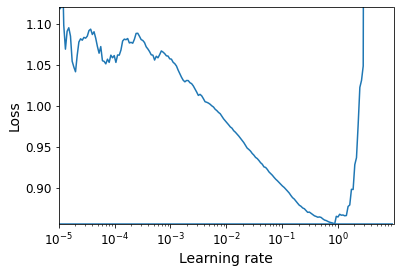

In [30]:
batch_size = 32
tf.keras.backend.clear_session()
# define mode
gl_model = glove_model(length, vocab_size, embed)
# get rates and losses
rates, losses = find_learning_rate(gl_model, [X_tr, X_tr, X_tr], y_t, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [27]:
# 1cycle scheduler
class OneCycleScheduler(keras.callbacks.Callback):
    
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_momentum = 0.95
        self.min_momentum = 0.85
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
            momentum = self._interpolate(0, self.half_iteration, self.max_momentum, self.min_momentum)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
            momentum = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.min_momentum, self.max_momentum)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
            momentum = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.max_momentum, self.min_momentum)
            momentum = max(momentum, self.max_momentum)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        K.set_value(self.model.optimizer.momentum, momentum)

In [33]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

n_epochs = 15
batch_size = 32
# instantiate 1cycle callback
onecycle = OneCycleScheduler(len(X_tr) // batch_size * n_epochs, max_rate=0.1)
# define mode
gl_model = glove_model(length, vocab_size, embed)
gl_model.fit([X_tr, X_tr, X_tr], y_t, epochs=n_epochs, batch_size=batch_size, 
             validation_data=([X_vl, X_vl, X_vl], y_v), callbacks=[onecycle])
gl_model.evaluate([X_vl, X_vl, X_vl], y_v)

Epoch 1/15
200/200 [==============================] - 3s 8ms/step - loss: 0.7484 - accuracy: 0.6118 - val_loss: 0.5455 - val_accuracy: 0.7309
Epoch 2/15
200/200 [==============================] - 2s 12ms/step - loss: 0.5510 - accuracy: 0.7359 - val_loss: 0.4844 - val_accuracy: 0.7709
Epoch 3/15
200/200 [==============================] - 1s 7ms/step - loss: 0.5376 - accuracy: 0.7382 - val_loss: 0.4924 - val_accuracy: 0.7647
Epoch 4/15
200/200 [==============================] - 1s 7ms/step - loss: 0.5178 - accuracy: 0.7535 - val_loss: 0.5054 - val_accuracy: 0.7691
Epoch 5/15
200/200 [==============================] - 1s 7ms/step - loss: 0.5123 - accuracy: 0.7599 - val_loss: 0.4852 - val_accuracy: 0.7682
Epoch 6/15
200/200 [==============================] - 1s 7ms/step - loss: 0.4938 - accuracy: 0.7824 - val_loss: 0.4736 - val_accuracy: 0.7798
Epoch 7/15
200/200 [==============================] - 1s 7ms/step - loss: 0.5030 - accuracy: 0.7693 - val_loss: 0.4789 - val_accuracy: 0.7771
Epoch

[0.4729601740837097, 0.7850799560546875]

In [34]:
X_tst = encode_data(tokenizer, X_test, length)
print('Shape of training data:', X_tst.shape)

Shape of training data: (3263, 44)


In [36]:
# create submission file
test["target"] = gl_model.predict([X_tst, X_tst, X_tst]).round().astype(int)
submission = test[["id", "target"]]
submission.to_csv("sub_ss.csv",index=False)